<a href="https://colab.research.google.com/github/olyandrevn/OctoPack-LLM/blob/main/OctoPackExplorationTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A recent paper 📜 [OctoPack: Instruction Tuning Code Large Language Models](https://arxiv.org/pdf/2308.07124.pdf) from 🤗 BigCode initiative presents an interesting use-case for commits: the authors propose to use them as a source of natural language instructions for code-related tasks. As part of this work, several novel models and datasets have been released to open-source.

In this task, we invite you to get familiar with OctoPack and experiment a little with some of the released datasets. Specifically:

* Read 📜 OctoPack: Instruction Tuning Code Large Language Models.
* Do some data exploration for 🤗 [CommitPackFt](https://www.koreancosmetic.cy/products/hydrophilic-cleansing-balm-by-heimish?_pos=6&_fid=1e1b01dfd&_ss=c) – a filtered dataset of commits which should be high-quality enough to serve as instructions.
* Evaluate 🤗 [Refact-1.6B](https://huggingface.co/smallcloudai/Refact-1_6B-fim#chat-format) model on the [HumanEvalFix](https://huggingface.co/datasets/bigcode/humanevalpack) for Python language from 🤗 HumanEvalPack benchmark using the setup and the metrics from the paper. Some qualitative analysis of the results would be appreaciated as well!

    * Note: Refact-1.6B is a smaller model introduced later by another party, also fine-tuned on CommitPackFt dataset, chosen because the models from the paper are likely too big for comfortable inferencing with freely available computational resources. It supports both Fill-in-the-Middle and Chat formats, the latter should probably be more convenient for this task.

* An open-ended question: based on what you read in the paper and your results, what do you think of commits as a source of natural language instructions for code editing? Any possible pitfalls?



In [1]:
!pip install datasets
!pip install evaluate

### Exploration of [CommitPackFt](https://huggingface.co/datasets/bigcode/commitpackft)

Let's look at CommitPackFt dataset with Python language.

In [2]:
from datasets import load_dataset
commitpackft = load_dataset("bigcode/commitpackft", "python")["train"]

The structure of one sample looks like this.



In [3]:
commitpackft[0]

{'commit': 'e905334869af72025592de586b81650cb3468b8a',
 'old_file': 'sentry/queue/client.py',
 'new_file': 'sentry/queue/client.py',
 'old_contents': '"""\nsentry.queue.client\n~~~~~~~~~~~~~~~~~~~\n\n:copyright: (c) 2010 by the Sentry Team, see AUTHORS for more details.\n:license: BSD, see LICENSE for more details.\n"""\nfrom kombu import BrokerConnection\nfrom kombu.common import maybe_declare\nfrom kombu.pools import producers\n\nfrom sentry.conf import settings\nfrom sentry.queue.queues import task_queues, task_exchange\n\n\nclass Broker(object):\n    def __init__(self, config):\n        self.connection = BrokerConnection(**config)\n\n    def delay(self, func, *args, **kwargs):\n        payload = {\n            "func": func,\n            "args": args,\n            "kwargs": kwargs,\n        }\n\n        with producers[self.connection].acquire(block=False) as producer:\n            for queue in task_queues:\n                maybe_declare(queue, producer.channel)\n            producer

Since we want to estimate the quality of commit messages to understand if it's a good source for code editing instructions the most interesting fields for us will be:


*   `'message'`
*   `'old_contents'`
*  ` 'new_contents'`

In [4]:
def print_sample(sample):
    print(f"****     Commit message:     ****\n {sample['message']}")
    print(f"****     Old content:     ****\n {sample['old_contents']}\n")
    print(f"****     New content:     ****\n {sample['new_contents']}\n")

class CommitPackFt():
    def __init__(self, commitpackft):
        self.commitpackft = commitpackft

    def __getitem__(self, idx):
        print(f"############################## i = {idx} ######################################\n")
        print_sample(self.commitpackft[idx])

    def print(self, n):
        for i in range(n):
            print(f"############################## i = {i} ######################################\n")
            print_sample(self.commitpackft[i])

Here you can see some examples of retrieved commit message and code edits:

In [5]:
ds_commitpackft = CommitPackFt(commitpackft)

In [6]:
ds_commitpackft.print(50)

############################## i = 0 ######################################

****     Commit message:     ****
 Declare queues when broker is instantiated

****     Old content:     ****
 """
sentry.queue.client
~~~~~~~~~~~~~~~~~~~

:copyright: (c) 2010 by the Sentry Team, see AUTHORS for more details.
:license: BSD, see LICENSE for more details.
"""
from kombu import BrokerConnection
from kombu.common import maybe_declare
from kombu.pools import producers

from sentry.conf import settings
from sentry.queue.queues import task_queues, task_exchange


class Broker(object):
    def __init__(self, config):
        self.connection = BrokerConnection(**config)

    def delay(self, func, *args, **kwargs):
        payload = {
            "func": func,
            "args": args,
            "kwargs": kwargs,
        }

        with producers[self.connection].acquire(block=False) as producer:
            for queue in task_queues:
                maybe_declare(queue, producer.channel)
            

After carefully looking at the 50 first examples I came to this conclusion:


- Most of commit messages in the CommitPackFt are meaningful and definitely describe the code changes, but some commit messages contain only the idea of change without specifical instructions.

Of course a lot more examples should be reviewed to make more proper conclusions.

I will leave a few examples that, in my opinion, will not be very useful without additional context.


#### Examples:

##### Example 1:

Commit message references another commit, thus only by having the commit message as instruction and the code it's not clear which changes should be applied; the data from other commits is needed.

In [7]:
ds_commitpackft[1]

############################## i = 1 ######################################

****     Commit message:     ****
 Revert "Fix openweather unit tests"

This reverts commit 36e100e649f0a337228a6d7375358d23afd544ff.

Open Weather Map has reverted back to their old api or something like that...

****     Old content:     ****
 # -*- coding: utf-8 -*-
import bot_mock
from pyfibot.modules import module_openweather
from utils import check_re


bot = bot_mock.BotMock()


def test_weather():
    regex = u'Lappeenranta, FI: Temperature: \d+.\d\xb0C, feels like: \d+.\d\xb0C, wind: \d+.\d m/s, humidity: \d+%, pressure: \d+ hPa, cloudiness: \d+%'
    check_re(regex, module_openweather.command_weather(bot, None, "#channel", 'lappeenranta')[1])


def test_forecast():
    regex = u'Lappeenranta, Finland: tomorrow: \d+.\d-\d+.\d \xb0C \(.*?\), in 2 days: \d+.\d-\d+.\d \xb0C \(.*?\), in 3 days: \d+.\d-\d+.\d \xb0C \(.*?\)'
    check_re(regex, module_openweather.command_forecast(bot, None, "#channel", 'lap

##### Example 2:

Commit message says: "Fix image path in manifest", only looking at difference between old/new code we can say which change this message implies: that in field `"images"` in paths of files parent directory name `"images"` should be added.

In [8]:
ds_commitpackft[6]

############################## i = 6 ######################################

****     Commit message:     ****
 Fix image path in manifest

****     Old content:     ****
 # -*- coding: utf-8 -*-
# © 2013-2016 Numérigraphe SARL
# License AGPL-3.0 or later (http://www.gnu.org/licenses/agpl.html).

{
    "name": "Hierarchical Inventory adjustments",
    "summary": "Group several Inventory adjustments in a master inventory",
    "version": "8.0.2.0.0",
    "depends": ["stock"],
    "author": u"Numérigraphe,Odoo Community Association (OCA)",
    "category": "Warehouse Management",
    "data": ["views/stock_inventory_view.xml",
             "wizard/generate_inventory_view.xml"],
    "images": ["inventory_form.png",
               "inventory_form_actions.png",
               "wizard.png"],
    'license': 'AGPL-3',
    'installable': True
}


****     New content:     ****
 # -*- coding: utf-8 -*-
# © 2013-2016 Numérigraphe SARL
# License AGPL-3.0 or later (http://www.gnu.org/licenses/agpl.ht

##### Example 3:

Commit message requests change in email address without specifying new address.

I think in this case while training model can remember new email from new code instead of learning the pattern of such message, so specifying the exact new address will be more useful instruction.

In [9]:
ds_commitpackft[8]

############################## i = 8 ######################################

****     Commit message:     ****
 Modify the author email address

****     Old content:     ****
 #!/usr/bin/env python
from distutils.core import setup

packages = [
    'upho',
    'upho.phonon',
    'upho.harmonic',
    'upho.analysis',
    'upho.structure',
    'upho.irreps',
    'upho.qpoints',
    'group',
]
scripts = [
    'scripts/upho_weights',
    'scripts/upho_sf',
    'scripts/upho_qpoints',
    'scripts/upho_fit',
]
setup(name='upho',
      version='0.5.3',
      author="Yuji Ikeda",
      author_email="ikeda.yuji.6m@kyoto-u.ac.jp",
      packages=packages,
      scripts=scripts,
      install_requires=['numpy', 'h5py', 'phonopy'])


****     New content:     ****
 #!/usr/bin/env python
from distutils.core import setup

packages = [
    'upho',
    'upho.phonon',
    'upho.harmonic',
    'upho.analysis',
    'upho.structure',
    'upho.irreps',
    'upho.qpoints',
    'group',
]
scripts = [
    

##### Example 4:

Commit asks for version change, without specifying to which version.

I think this instruction can be confusing.

In [10]:
ds_commitpackft[9]

############################## i = 9 ######################################

****     Commit message:     ****
 Change the version of the package.
****     Old content:     ****
 
from setuptools import setup, find_packages
import sys, os

version = '1.1.1'

setup(
    name = 'daprot',
    version = version,
    description = "daprot is a data prototyper and mapper library.",
    packages = find_packages( exclude = [ 'ez_setup'] ),
    include_package_data = True,
    zip_safe = False,
    entry_points = {},
    author = 'Bence Faludi',
    author_email = 'bence@ozmo.hu',
    license = 'GPL',
    install_requires = [
        'dm',
        'funcomp',
    ],
    test_suite = "daprot.tests"
)


****     New content:     ****
 
from setuptools import setup, find_packages
import sys, os

version = '1.1.2'

setup(
    name = 'daprot',
    version = version,
    description = "daprot is a data prototyper and mapper library.",
    packages = find_packages( exclude = [ 'ez_setup'] ),
    includ

##### Example 5:

Commit asks to "Include data files in built package"; in this case data has .JSON extension, but it's not always the case.

I think this instruction can be confusing.

In [11]:
ds_commitpackft[13]

############################## i = 13 ######################################

****     Commit message:     ****
 Include data files in built package

****     Old content:     ****
 # !/usr/bin/env python

from setuptools import setup, find_packages

setup(name='symbtrsynthesis',
      version='1.0.1-dev',
      description='An (adaptive) synthesizer for SymbTr-MusicXML scores',
      author='Hasan Sercan Atli',
      url='https://github.com/hsercanatli/symbtrsynthesis',
      packages=find_packages(),
      include_package_data=True, install_requires=['numpy']
      )


****     New content:     ****
 # !/usr/bin/env python

from setuptools import setup, find_packages

setup(name='symbtrsynthesis',
      version='1.0.1-dev',
      description='An (adaptive) synthesizer for SymbTr-MusicXML scores',
      author='Hasan Sercan Atli',
      url='https://github.com/hsercanatli/symbtrsynthesis',
      packages=find_packages(),
      package_data={'symbtrsynthesis': ['data/*.json']},
      i

##### Example 6:

The "fix homepage" part of commit message can be confusing, because no new homepage provided.

In [12]:
ds_commitpackft[27]

############################## i = 27 ######################################

****     Commit message:     ****
 Increment version number, fix homepage

****     Old content:     ****
 from setuptools import setup

setup(
    name='opengithub',
    version='0.1.2',
    author='Kevin Schaul',
    author_email='kevin.schaul@gmail.com',
    url='http://www.kevinschaul.com',
    description='Open your project in GitHub from the command line.',
    long_description='Check out the project on GitHub for the latest information <http://github.com/kevinschaul/open-in-github>',
    license='MIT',
    classifiers=[
    'Development Status :: 4 - Beta',
    'Environment :: Console',
    'Framework :: Django',
    'Intended Audience :: Developers',
    'License :: OSI Approved :: MIT License',
    'Natural Language :: English',
    'Operating System :: Unix',
    'Programming Language :: Python',
    'Topic :: Software Development',
    ],
    packages=[
    'opengithub',
    ],
    entry_points = {

##### Example 7:

Commit message doesn't specify how dependencies should be updated; in this case some dependencies just commented(removed), but updating dependencies typically involves specifying newer versions of packages or adding/removing dependencies.

In [13]:
ds_commitpackft[29]

############################## i = 29 ######################################

****     Commit message:     ****
 Update deps for initial release

****     Old content:     ****
 __version__ = '0.1'

import os

from setuptools import setup, find_packages

here = os.path.abspath(os.path.dirname(__file__))
README = open(os.path.join(here, 'README.rst')).read()
CHANGES = open(os.path.join(here, 'CHANGES.rst')).read()

setup(name='retools',
      version=__version__,
      description='Redis Tools',
      long_description=README + '\n\n' +  CHANGES,
      classifiers=[
        "Intended Audience :: Developers",
        "Programming Language :: Python",
        ],
      keywords='cache redis queue',
      author="Ben Bangert",
      author_email="ben@groovie.org",
      url="",
      license="MIT",
      packages=find_packages(),
      include_package_data=True,
      zip_safe=False,
      tests_require = ['pkginfo', 'Mock>=0.7', 'nose'],
      install_requires=[
          "setproctitle>=1.1

##### Example 8:

Commit message requests link update, but no new link.

In [14]:
ds_commitpackft[34]

############################## i = 34 ######################################

****     Commit message:     ****
 Update outdated link to repository, per @cknv

****     Old content:     ****
 import os
import sys
from distutils.core import setup

if sys.version_info < (3,):
    print('\nSorry, but Adventure can only be installed under Python 3.\n')
    sys.exit(1)

README_PATH = os.path.join(os.path.dirname(__file__), 'adventure', 'README.txt')
with open(README_PATH, encoding="utf-8") as f:
    README_TEXT = f.read()

setup(
    name='adventure',
    version='1.4',
    description='Colossal Cave adventure game at the Python prompt',
    long_description=README_TEXT,
    author='Brandon Craig Rhodes',
    author_email='brandon@rhodesmill.org',
    url='https://bitbucket.org/brandon/adventure/overview',
    packages=['adventure', 'adventure/tests'],
    package_data={'adventure': ['README.txt', '*.dat', 'tests/*.txt']},
    classifiers=[
        'Development Status :: 6 - Mature',
      

##### Example 9:

Commit message requests URL update, but no new URL; other part of commit is fine.

In [15]:
ds_commitpackft[35]

############################## i = 35 ######################################

****     Commit message:     ****
 Remove dev indentifier; crank Development Status; updated URL to point to project page

****     Old content:     ****
 from setuptools import setup

setup(
    name='kf5py',
    py_modules = ['kf5py'],
    version='0.1.dev5',
    author='Chris Teplovs',
    author_email='dr.chris@problemshift.com',
    url='https://github.com/problemshift/kf5py',
    license='LICENSE.txt',
    description='Python-based utilities for KF5.',
    install_requires=[
        "requests >= 2.3.0"
    ],
    classifiers=[
        "Programming Language :: Python",
        "Programming Language :: Python :: 2",
        "Programming Language :: Python :: 3",
        "Development Status :: 1 - Planning",
        "Intended Audience :: Science/Research",
        "License :: OSI Approved :: MIT License",
        "Operating System :: OS Independent"
    ]
)


****     New content:     ****
 from setuptools

##### Example 10:

Commit message is confusing because it's not clear what is meant by wrong path.

In [16]:
ds_commitpackft[36]

############################## i = 36 ######################################

****     Commit message:     ****
 Fix wrong path in readme

****     Old content:     ****
 from setuptools import setup

version = "0.10.2"


setup(
    name="setuptools-rust",
    version=version,
    author="Nikolay Kim",
    author_email="fafhrd91@gmail.com",
    url="https://github.com/PyO3/setuptools-rust",
    keywords="distutils setuptools rust",
    description="Setuptools rust extension plugin",
    long_description="\n\n".join(
        (open("README.rst").read(), open("CHANGES.rst").read())
    ),
    license="MIT",
    packages=["setuptools_rust"],
    install_requires=["semantic_version>=2.6.0", "toml>=0.9.0"],
    zip_safe=True,
    classifiers=[
        "Topic :: Software Development :: Version Control",
        "License :: OSI Approved :: MIT License",
        "Intended Audience :: Developers",
        "Programming Language :: Python :: 2",
        "Programming Language :: Python :: 2.7",
   

##### Example 11:

Commit message says "Add todo for future work", but it's unclear what exactly author means, it really can be anything.

In [17]:
ds_commitpackft[144]

############################## i = 144 ######################################

****     Commit message:     ****
 Add todo for future work

****     Old content:     ****
 ﻿import xbmc,xbmcaddon,xbmcgui,json,random

def getAllMovies():
  rpccmd = {'jsonrpc': '2.0', 'method': 'VideoLibrary.GetMovies', 'params': { 'properties': [ 'file' ] }, 'id': 'libMovies'}
  rpccmd = json.dumps(rpccmd)
  result = xbmc.executeJSONRPC(rpccmd)
  result = json.loads(result)
  return result

addon     = xbmcaddon.Addon()
addonName = addon.getAddonInfo('name')
addonIcon = addon.getAddonInfo('icon')

movies = getAllMovies()
movie  = random.choice(movies['result']['movies'])
time   = 5000

xbmc.executebuiltin('PlayMedia(%s)'%(movie['file']))
xbmc.executebuiltin('Notification(%s, %s %s, %d, %s)'%(addonName,"Playing ",movie['label'],time,addonIcon))

****     New content:     ****
 ﻿import xbmc,xbmcaddon,xbmcgui,json,random

def getAllMovies():
  # TODO: determine all/unwatched/watched from settings...
  # rpc

#### Statistics

Based on examples above I calculated basic statistics: I chose several words that might be used in unusefull commit messages and calculated how many samples have those words in messages.

In [18]:
import pandas as pd

search_words = ['email', 'mail', 'hostname', 'version', 'link', 'url', 'path', 'todo']
search_dict = {word : 0 for word in search_words}

for pack in commitpackft:
    msg = pack['message'].lower()
    for word in search_words:
        if msg.find(word) != -1:
            search_dict[word] += 1

##### The number of messages with those words:

In [19]:
search_dict

{'email': 424,
 'mail': 761,
 'hostname': 41,
 'version': 3038,
 'link': 457,
 'url': 1956,
 'path': 1068,
 'todo': 120}

##### The fraction of messages with those words:

In [20]:
search_dict2 = {
    word : float(f'{val / len(commitpackft):.5f}')
    for word, val in search_dict.items()
}

search_dict2

{'email': 0.00757,
 'mail': 0.01358,
 'hostname': 0.00073,
 'version': 0.05423,
 'link': 0.00816,
 'url': 0.03491,
 'path': 0.01906,
 'todo': 0.00214}

### Evaluating [Refact-1.6B](https://huggingface.co/smallcloudai/Refact-1_6B-fim#chat-format) model on the [HumanEvalFix](https://huggingface.co/datasets/bigcode/humanevalpack) for Python language

In [21]:
from datasets import load_dataset

import logging
logging.basicConfig(level='ERROR')

import matplotlib.pyplot as plt
from IPython.display import clear_output
import argparse
import numpy as np
from pprint import pprint
import sys
import csv
import os
import torch
import zlib
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import evaluate

In [22]:
from google.colab import drive
import os

drive.mount('/content/drive')
save_path = '/content/drive/My Drive/OctoPackExplorationTask'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Prompt setup

To evaluate [Refact-1.6B](https://huggingface.co/smallcloudai/Refact-1_6B-fim) model I used the chat format; the authors suggest the following prompt template:


```
prompt_template = "<empty_output>SYSTEM {system}\n" \
                  "<empty_output>USER {query}\n" \
                  "<empty_output>ASSISTANT"
prompt = prompt_template.format(system="You are a programming assistant",
                                query="How do I sort a list in Python?")
```

To create the prompt for out use let's look at [HumanEvalPack](https://huggingface.co/datasets/bigcode/humanevalpack) dataset; since we want to evaluate model on HumanEvalFix problem we will need the following fields:


*   `entry_point` -- stores the name of function
*   `declaration` -- stored the function declaration
*   `buggy_solution` -- stores baggy solution
*   `test` -- stores test that check the correctness of generated function

So we'll be genereting the prompts in this way:

```
prompt = self.prompt_template.format(
                system="You are a programming assistant",
                query="Fix bugs in " + item['entry_point'] + "\n" + item['declaration'] + item['buggy_solution'])
```









In [23]:
ds = load_dataset("bigcode/humanevalpack", "python")["test"]
ds[0]

{'task_id': 'Python/0',
 'prompt': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n',
 'declaration': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n',
 'canonical_solution': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold:\n                    return True\n\n    return False\n',
 'buggy_solution': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = elem - elem2\n             

#### Pass@k metric

To evaluate how good LLM generates code authors use [Pass@k metric](https://huggingface.co/spaces/evaluate-metric/code_eval); as in the article I focused on calculating Pass@1 and used the following parameters from article for code generation:



*   `n_samples = 20` -- number of sequences that model generates for 1 prompt
*   `temperature = 0.2` -- sampling temperature
*   `top_p = 0.95`

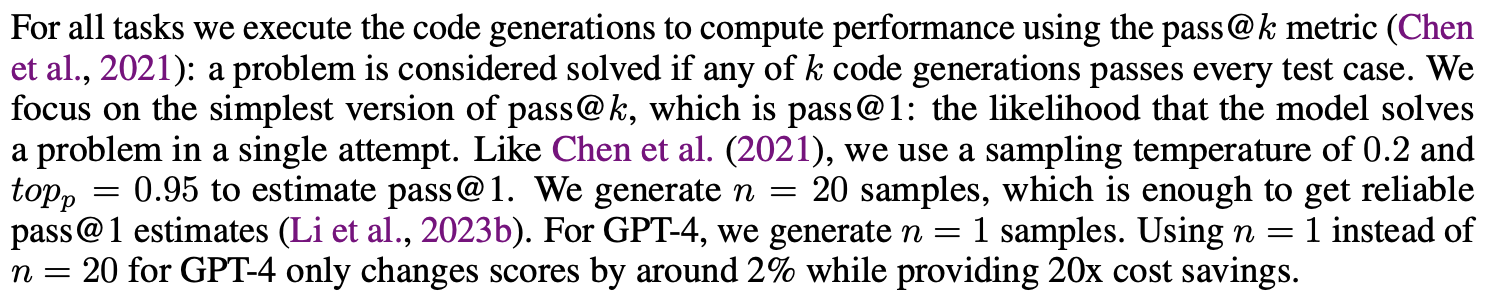

#### Experiment



*   `class ExperimentArgs` -- the `class` is used for setting up all the parameters;
*   `class Experiment` -- the `class` is used for generating code sequences using prompt and calculating *pass@k*;

    *   `setup()` method sets up the tokenizer, model;
    *   `run()` method generates chunks of code and calculated *pass@k* for generated sequences; all data is saved to `.csv`;


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["HF_ALLOW_CODE_EVAL"] = "1"

class ExperimentArgs:
    def __init__(self,
                 N=None,
                 k=1,
                 n_samples=20,
                 temperature=0.2,
                 top_p=0.95,
                 checkpoint="smallcloudai/Refact-1_6B-fim"):
        """
        N : int -- The number of samples to process. If None, will use the length of the dataset.
        k : int -- The number of code candidates to consider in the evaluation.
        n_samples : int -- The number of samples to generate for each prompt.
        temperature : float -- The temperature parameter for generation, controlling randomness.
        top_p : float -- The top-p parameter for generation, controlling diversity.
        checkpoint : str -- The model checkpoint path.
        model_name : str -- The name of the model, extracted from the checkpoint path.
        """
        self.N = N
        self.k = k
        self.n_samples = n_samples
        self.temperature = temperature
        self.top_p = top_p
        self.checkpoint = checkpoint
        self.model_name = os.path.split(checkpoint)[1]

class Experiment:
    def __init__(self, filelog, filetable, args : ExperimentArgs):
        self.args = args
        self.filelog = filelog
        self.filetable = filetable
        self.pass_at_k = evaluate.load("code_eval")
        self.score_name = f"pass@{self.args.k}"

        df = pd.DataFrame(columns=['text', self.score_name])
        df.to_csv(self.filetable, mode='a', index=False)

    def setup(self):
        with open(self.filelog, 'a') as f:
            f.write(f"using device: {device}\n")
            f.write("Loading Model...\n\n")

        self.dataset = load_dataset("bigcode/humanevalpack", "python")["test"]
        if self.args.N is None:
            self.args.N = len(self.dataset)
        self.prompt_template = "<empty_output>SYSTEM {system}\n" \
                               "<empty_output>USER {query}\n" \
                               "<empty_output>ASSISTANT"

        self.tokenizer = AutoTokenizer.from_pretrained(self.args.checkpoint)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = AutoModelForCausalLM.from_pretrained(
            self.args.checkpoint,
            trust_remote_code=True).to(device)
        self.model.eval()
        with open(self.filelog, 'a') as f:
            f.write("Model loading is done!\n\n")

        self.scores = {
            self.score_name: []
        }

    def generate_sequences(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(device)
        outputs = self.model.generate(
            input_ids=inputs['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device),
            max_length=2*len(prompt),
            temperature=self.args.temperature,
            top_p=self.args.top_p,
            num_return_sequences=self.args.n_samples)
        return [self.tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    def get_code(self, sequence):
        parts = sequence.split("ASSISTANT")
        if len(parts) > 1:
            code = parts[1].strip()
        else:
            code = ""

        return code

    def run(self):
        with open(self.filelog, 'a') as f:
            f.write("Start experiment...\n\n")

        for i in tqdm(range(self.args.N)):
            item = self.dataset[i]
            prompt = self.prompt_template.format(
                system="You are a programming assistant",
                query="Fix bugs in " + item['entry_point'] + "\n" + item['declaration'] + item['buggy_solution'])

            generated_sequences = self.generate_sequences(prompt)
            generated_code = [self.get_code(seq) for seq in generated_sequences]

            score, _ = self.pass_at_k.compute(references=[item['test']], predictions=[generated_code], k=[self.args.k])
            self.scores[self.score_name].append(score[self.score_name])

            data = {
                'text': ["\n\n".join(generated_sequences)],
                self.score_name: [score[self.score_name]],
            }
            df = pd.DataFrame(data)
            df.to_csv(self.filetable, mode='a', header=False, index=False)

        self.scores[self.score_name] = np.asarray(self.scores[self.score_name])
        with open(self.filelog, 'a') as f:
            f.write(f"{self.score_name} = {self.scores[self.score_name].mean()}\n")
            f.write("Experiment done!\n\n")

#### Run Experiment

In [25]:
filelog = save_path + '/exp-log-v1.txt'
filetable = save_path + '/exp-table-v1.csv'

experiment_args = ExperimentArgs()
experiment = Experiment(filelog, filetable, experiment_args)
experiment.setup()
experiment.run()

100%|██████████| 164/164 [11:11<00:00,  4.10s/it]


In [26]:
with open(filelog, 'r') as file:
    content = file.read()
    print(content)

using device: cuda
Loading Model...

Model loading is done!

Start experiment...

pass@1 = 0.23414634146341462
Experiment done!




Based on the results I got I thing that very good carefully filtered commits can be successfully used as instructions for code editing, but it should be correctly prompted.

All files are available in [repository](https://github.com/olyandrevn/OctoPack-LLM/tree/main/data).